* 라이브러리

In [22]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

* 데이터

In [2]:
import os
file_path = '../data/ex10/fra-eng/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
178401,You're too suspicious about everything.,Vous êtes trop suspicieuse de tout.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
78172,How did you become a cop?,Comment es-tu devenue policière ?,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
116783,The path ran along the river.,Le chemin menait le long de la rivière.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
159214,We see each other almost every day.,On se voit presque tous les jours.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
135024,Can we move on to the next item?,Pouvons-nous passer à l'objet suivant ?,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [3]:
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
7624,I had to stop.,Il me fallut cesser.
38545,He jimmied the lock.,Il a forcé la serrure.
14118,Congratulations!,Tous mes vœux !
38986,I can't change this.,Je ne peux pas changer ça.
15005,I have returned.,Je suis revenu.


In [4]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 50000


,eng,fra
5952,She is upset.,\t Elle est perturbée. \n
6954,Be reasonable.,\t Soyez raisonnables ! \n
33080,I was very nervous.,\t J'étais très nerveux. \n
37725,Can we believe that?,\t Pouvons-nous y croire ? \n
8799,She likes him.,\t Elle l'aime. \n


In [5]:
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[19, 4, 7], [19, 4, 7], [19, 4, 7]]

In [6]:
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[10, 1, 19, 5, 1, 31, 1, 11],
 [10, 1, 15, 5, 12, 16, 29, 2, 14, 1, 11],
 [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]

In [36]:
# index 사전 정리
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [7]:
# 0번 토큰
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73


In [8]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 21
프랑스어 시퀀스의 최대 길이 69


In [9]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73
영어 시퀀스의 최대 길이 21
프랑스어 시퀀스의 최대 길이 69


In [32]:
fra_tokenizer.index_word[11], fra_tokenizer.word_index[eos_token]

('\n', 11)

In [34]:
fra_tokenizer.index_word[10], fra_tokenizer.word_index[sos_token]

('\t', 10)

In [10]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [11]:
print(decoder_input[:3])
print(decoder_target[:3])

[[10, 1, 19, 5, 1, 31, 1], [10, 1, 15, 5, 12, 16, 29, 2, 14, 1], [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1]]
[[1, 19, 5, 1, 31, 1, 11], [1, 15, 5, 12, 16, 29, 2, 14, 1, 11], [1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]


In [12]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21)
프랑스어 입력데이터의 크기(shape) : (50000, 69)
프랑스어 출력데이터의 크기(shape) : (50000, 69)


In [13]:
print(encoder_input[0])

[19  4  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [14]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21, 52)
프랑스어 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 69, 73)


In [15]:
n_of_val = 3000 # 검증 데이터

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 21, 52)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 69, 73)


## model train

In [16]:
# Encoder(영어) Input1 입력 텐서 생성.
encoder_inputs = Input(shape=(None, eng_vocab_size))

# input1 -> LSTM => output, h, c
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) # output은 필요없음

encoder_states = [state_h, state_c]

In [17]:
# Decoder(프랑스어) 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size))
# input2 -> LSTM => output,
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

In [18]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [19]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 52)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 73)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        316416      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

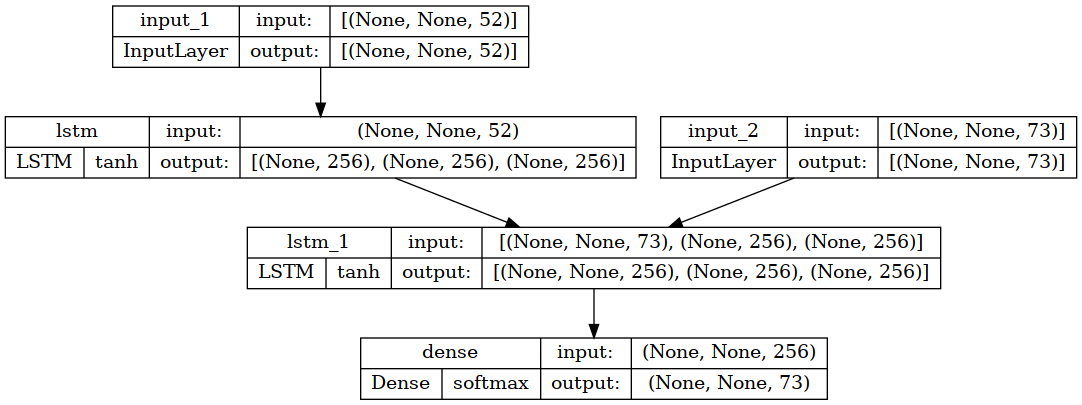

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

여기서 LSTM은 사실상 1개라는 것, 왜냐하면 LSTM은 input1 을 받아 h,c 를 만들고, 새로운 input2에서 정답과 비교하여 train

In [21]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
368/368 [==============================] - 10s 19ms/step - loss: 0.9466 - val_loss: 0.8195
Epoch 2/50
368/368 [==============================] - 6s 17ms/step - loss: 0.5857 - val_loss: 0.6795
Epoch 3/50
368/368 [==============================] - 6s 17ms/step - loss: 0.4882 - val_loss: 0.5915
Epoch 4/50
368/368 [==============================] - 6s 17ms/step - loss: 0.4293 - val_loss: 0.5334
Epoch 5/50
368/368 [==============================] - 6s 17ms/step - loss: 0.3901 - val_loss: 0.5065
Epoch 6/50
368/368 [==============================] - 6s 17ms/step - loss: 0.3612 - val_loss: 0.4710
Epoch 7/50
368/368 [==============================] - 6s 17ms/step - loss: 0.3393 - val_loss: 0.4532
Epoch 8/50
368/368 [==============================] - 6s 17ms/step - loss: 0.3217 - val_loss: 0.4316
Epoch 9/50
368/368 [==============================] - 6s 17ms/step - loss: 0.3073 - val_loss: 0.4214
Epoch 10/50
368/368 [==============================] - 6s 17ms/step - loss: 0.2951 - val_l

## model test

In [23]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 52)]        0         
                                                                 
 lstm (LSTM)                 [(None, 256),             316416    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 316,416
Trainable params: 316,416
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [25]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 73)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, None, 256),  337920      ['input_2[0][0]',                
                                 (None, 256),                     'input_3[0][0]',          

In [47]:
seq_index = 3

# input_seq = encoder_input[seq_index] # shape = (21,52)
input_seq = encoder_input[seq_index:seq_index+1] # shape = (1,21,52)
print(input_seq.shape)
input_seq

(1, 21, 52)


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [54]:
states_value = encoder_model.predict(input_seq) # state_h, state_c 를 꺼냄
print(np.array(states_value).shape)

1/1 [==============================] - 0s 19ms/step
(2, 1, 256)


In [58]:
target_seq = np.zeros((1, 1, fra_vocab_size))
print(target_seq.shape)
target_seq

(1, 1, 73)


array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [59]:
target_seq[0, 0, fra2idx['\t']] = 1. # fra2idx['\t']=10 즉, \t 시작토큰을 디코더에 입력

10

In [65]:
# decoder_model 은 input이 3개 (target_seq, state_h, state_c)
# decoder_output을 가져감
output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
print(output_tokens.shape)
output_tokens

1/1 [==============================] - 0s 18ms/step
(1, 1, 73)


array([[[2.1137444e-07, 9.9960428e-01, 1.9941392e-07, 1.1680594e-06,
         1.3788421e-06, 1.5760166e-06, 5.2148880e-06, 8.5275474e-08,
         2.4933104e-06, 3.5333414e-08, 3.1428447e-09, 2.9483285e-08,
         6.4589933e-08, 9.6207614e-06, 2.4770608e-04, 1.3202149e-08,
         2.9078598e-07, 1.2580705e-07, 5.1330329e-07, 4.3926284e-06,
         9.3355457e-06, 2.1605883e-12, 6.3183694e-07, 2.1716113e-08,
         1.4695527e-06, 3.5862240e-09, 3.7221595e-10, 9.6285750e-11,
         1.5743737e-09, 5.1791858e-07, 4.7780763e-06, 1.5757806e-08,
         5.5407462e-10, 8.0766210e-10, 3.2265827e-08, 1.5070448e-09,
         3.8201687e-08, 7.4192866e-07, 4.9538106e-05, 4.1368061e-05,
         4.9057130e-06, 1.3699521e-07, 2.1883124e-09, 1.9764095e-06,
         2.9297256e-10, 2.2412316e-10, 1.2141317e-07, 3.5911826e-11,
         5.4285604e-08, 2.0996374e-06, 2.1807149e-07, 1.3122216e-08,
         8.5857441e-12, 8.5707003e-10, 2.3461043e-06, 2.0896793e-10,
         2.2678119e-09, 1.3046977e

In [66]:
sampled_token_index = np.argmax(output_tokens[0, -1, :])
print(output_tokens[0, -1, :].shape)
sampled_token_index

(73,)


1

In [67]:
sampled_char = idx2fra[sampled_token_index]
sampled_char
# /t -> ' '

' '

In [68]:
decoded_sentence = ""
decoded_sentence += sampled_char # 예측 문자 추가

In [69]:
# <eos>에 도달하거나 최대 길이를 넘으면 중단.
if (sampled_char == '\n' or len(decoded_sentence) > max_fra_seq_len):
    print("hi")

In [70]:
# 예측 결과를 새로운 decoder input으로 사용
target_seq = np.zeros((1, 1, fra_vocab_size))
target_seq[0, 0, sampled_token_index] = 1.

In [71]:
# 첫번째 state만 encoder
# 이후는 decoder에서 업데이트된 state_value를 사용
states_value = [h, c]

In [72]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [73]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: Go.
정답 문장:  Bouge ! 
번역기가 번역한 문장:  va ! 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Hello!
정답 문장:  Bonjour ! 
번역기가 번역한 문장:  salut ! 
1/1 [==============================] - 0s 17ms/step
-----------------------------------
입력 문장: Got it!
정답 문장:  Compris ! 
번역기가 번역한 문장:  aidez-vous ! 
1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: Goodbye.
정답 문장:  Au revoir. 
번역기가 번역한 문장:  au lait. 
1/1 [==============================] - 0s 14ms/step
-----------------------------------
입력 문장: Hands off.
정답 문장:  Pas touche ! 
번역기가 번역한 문장:  trouve-toi ! 
